## Python によるデータ分析コンテスト実践 (Part 3)

本ドキュメントは FIT 2016 チュートリアル資料です．
各種データに対する Python によるデータ処理について，パッケージの利用例を紹介する．

## 目次

* 大規模データ処理 (Redshift)
  * Redshift にデータをロードする
  * Redshift による特徴量作成
  * Redshift でのクラスタサイズごとの実行時間の比較
* 大規模データ処理 (BigQuery)
  * BigQuery にデータをロードする
  * BigQuery による特徴量作成
  * BigQuery における実行時間
* 画像データ (OpenCV)
  * BRISK 特徴点の作成
* ~~時系列データ~~ (今回は扱わない)
  * ~~ARIMA モデルを使った季節性のある時系列データのモデル~~
* ~~自然言語データ~~ (今回は扱わない)
  * ~~NTLK による自然言語データの前処理~~
  * ~~自然言語データのスコアリング~~
  * ~~word2vec による英語・ロシア語の distributed representations~~

（後半の項目は時間の都合上，チュートリアルでは扱わない）

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

----

## 大規模データ処理 (Redshift)

※ 本セクションでは 100GB ほどのリレーショナルデータ（各テーブルのレコード数は 5 * 10^8 程度）の処理を想定する．
pandas は IO として SQL をサポートしている．SQL の利用は主に以下の様な場面でメリットがある．

* 複雑なリレーショナルデータは扱う場合，集約処理などを SQL によって簡潔に記述できる
* 大規模なデータを扱う場合，すべてのデータを手元の環境にロードすることなく SQL サーバーの計算リソースで処理できる

本セクションでは Redshift と BigQuery を使い pandas とデータのやり取りを行う利用例を紹介する．

### Redshift クラスタの起動

Redshift は AWS 上に起動した高密度ストレージノードあるいは高密度コンピュートノードによるクラスタ上で動作する．
下図のように AWS Console 画面から「Launch Cluster」を押してクラスタを起動するか，あるいは API 経由でクラスタを起動する．

![](http://ho.lc/files/559084cd.png)

以下ではクラスタを起動しているものとして扱う．

### Redshift へデータをインポートする

Redshift は S3 からデータをインポートすることができる．まず S3 へデータをアップロードする．

```
# S3 上にロードするデータをアップロードする
$ aws s3 cp diagnosis_head.csv.gz s3://kaggle-kohei/cervical_cancer/input/diagnosis_head.csv.gz
```

テーブルスキーマを定義して，`COPY` コマンドにより S3 のデータをテーブルにロードする．

```
# テーブルスキーマとテーブルを S3 からロードするための SQL を用意する
$ cat > schema.sql
CREATE TABLE IF NOT EXISTS drugs(
  drug_id varchar,
  NDC11 varchar,
  drug_name varchar,
  BGI varchar,
  BB_USC_code varchar,
  BB_USC_name varchar,
  drug_generic_name varchar,
  drug_strength varchar,
  drug_form varchar,
  package_size numeric,
  package_description varchar,
  manufacturer varchar,
  NDC_start_date date
) COMPOUND SORTKEY(drug_id);

COPY drugs
FROM 's3://s3-kohei-us-west2/cervical_cancer/data/input/drugs.csv.gz'
CREDENTIALS 'aws_access_key_id=XXXXXXXXXXXXXXXXXX;aws_secret_access_key=XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
IGNOREHEADER 1 CSV GZIP;
```

Redshift は PostgreSQL をベースとしたシステムであり，PostgreSQL と同様に `psql` コマンドを利用できる．
`psql` コマンド経由で Redshift にクエリを発行する．

```
# デーブルを作成し，S3 から gzip 圧縮ファイルをテーブルにロードする
$ psql "dbname='genentech' port='5439' user='kohei_ozaki' host='${REDSHIFT_HOST}'" < schema.sql
Password:
```

### Redshift にクエリを発行して DataFrame を得る

pandas の `pandas.read_sql()` 関数によって Redshift にクエリを発行し，結果を DataFrame として受け取ることができる．
コネクションオブジェクトを作成して `read_sql()` 関数にクエリと一緒に渡す．

In [6]:
import pandas as pd
import psycopg2 as pg
import os


conn_string = ' '.join([
    "dbname='genentech'",
    "port='5439'",
    "user='kohei_ozaki'",
    "password='{}'".format(os.environ['REDSHIFT_PWD']),
    "host='{}'".format(os.environ['REDSHIFT_HOST']),
])
conn = pg.connect(conn_string)

type(pd.read_sql("SELECT * FROM drugs LIMIT 10", conn))

pandas.core.frame.DataFrame

----

## 大規模データ処理 (BigQuery)

BigQuery は GCP (Google Cloud Platform) におけるフルマネージドなクラウドデータウェアハウスである．Redshift がクラスタの起動と運用を必要とする一方で，[BigQuery はサーバーレス アーキテクチャ](http://googlecloudplatform-japan.blogspot.jp/2016/09/bigquery.html)であり，クラスタを意識する必要がない．

### GCP のアカウント設定

Terminal (Jupyter notebook の New タブから Terminal を起動できる) からログインしておくと Cloud SDK の各種ツールを使い GCP のサービスを利用することができるようになる．

![](http://ho.lc/files/b44930d2.png)

Terminal から `gcloud auth login` コマンドを実行して認証する．

ログイン後， `gcloud config set project <PROJECT_ID>` コマンドでプロジェクト名をセットする．

In [9]:
!gcloud config set project kaggle-kohei

### BigQuery にデータセットをロードする

ここでは Google Cloud Storage へファイルをアップロードして，BigQuery のテーブルとしてロードする手順を踏む．GCP SDK が提供するツールの一つである `gsutil` コマンドを使い，ローカル環境のデータを Google Cloud Storage へアップロードする．

```
$ gsutil -o GSUtil:parallel_composite_upload_threshold=150M cp \
  /mnt/cervical_cancer/patient_activity_head.csv \
  gs://kaggle-kohei.appspot.com/cervical_cancer/
```

ロードしたいデータに対応する schema ファイルを JSON 形式で作成する：

```
$ cat > patient_activity_head.json
[
  {
    "name": "patient_id",
    "type": "integer"
  },
  {
    "name": "activity_type",
    "type": "string"
  },
  {
    "name": "activity_year",
    "type": "integer"
  },
  {
    "name": "activity_month",
    "type": "integer"
  }
]
```

kaggle-kohei プロジェクトに cervical_cancer データセットを作成し，この下に patient_activity_head テーブルとしてロードする．

```
$ bq mk cervical_cancer
$ bq load --skip_leading_rows 1 \
  kaggle-kohei:cervical_cancer.patient_activity_head \
  gs://kaggle-kohei.appspot.com/cervical_cancer/patient_activity_head.csv \
  patient_activity_head.json
Waiting on bqjob_r3502f50ae459a88_00000156de6cf4d0_1 ... (89s) Current status: DONE
```

（※ 注意：圧縮ファイルからの batch load も可能だが，ファイルサイズの制限がある．そのためファイルを分割した後でそれぞれのファイルを圧縮し，batch load させることが現実的．具体的な手段については後述する）

## クエリのデータ処理コストの見積もり

BigQuery のクエリごとのコストは走査バイト数によって決まる（2016年9月8日時点で 5 USD per 1TB）．ドライランすることで事前に走査バイト数を調べ，かかるコストを見積もることができる．

In [10]:
!bq query --dry_run \
    'SELECT patient_id, COUNT(*) AS num_activity FROM cervical_cancer.patient_activity_head GROUP BY patient_id'

Query successfully validated. Assuming the tables are not modified, running this query will process 2097267112 bytes of data.


In [13]:
# 走査バイト数 (2097267112 bytes ~= 0.002 TB)
2097267112 / 1024.0 / 1024.0 / 1024.0 / 1024.0

0.0019074533265666105

In [14]:
# 1 TB あたり 5 USD なので 1 USD = 101 JPY とした場合，見積もりコストは 0.97 円となる．
2097267112 / 1024.0 / 1024.0 / 1024.0 / 1024.0 * 5.0 * 101.80

0.9708937432224047

このクエリによって発生するコストは 1 円ほどであると見積もることができる．

### BigQuery で予測モデルの特徴量を作成して pandas データフレームを HDF5 コンテナに圧縮して保存する

pandas には BigQuery にクエリを発行してデータをロードするための `read_gbq()` 関数がある (0.18 以降)．
BigQuery で特徴量を作成し，ローカル環境にて HDF5 コンテナに圧縮して保存する．

In [3]:
import pandas as pd

In [4]:
query = """
SELECT
  patient_id,
  COUNT(*) AS patient_activity_count,
  SUM(CASE WHEN activity_type='R' THEN 1 ELSE 0 END) AS activity_type_r_count,
  SUM(CASE WHEN activity_type='A' THEN 1 ELSE 0 END) AS activity_type_a_count
FROM
  cervical_cancer.patient_activity_head
GROUP BY patient_id
LIMIT 100
"""

pd.read_gbq(query, 'kaggle-kohei').to_hdf('patient_activity_type_count.h5', 'X', complib='blosc', complevel=9)

Requesting query... ok.
Query running...
  Elapsed 12.56 s. Waiting...
Query done.
Processed: 2.7 Gb

Retrieving results...
  Got page: 1; 100% done. Elapsed 19.15 s.
Got 100 rows.

Total time taken 19.16 s.
Finished at 2016-09-07 12:10:43.


In [6]:
type(pd.read_hdf('patient_activity_type_count.h5', 'X'))

pandas.core.frame.DataFrame

### off topic: 実用上の注意点とオススメ

BigQuery から手元の環境へのデータ転送にはデータのサイズに応じて相応の時間がかかるため，注意すべきである．

大きなデータを扱い試行錯誤する場合は，`bq query` サブコマンドの `--destination_table` オプションを使うことを薦める．
BigQuery 上にテーブルを作成して，必要な場合だけ・必要なデータ量だけ `read_gbq()` で結果を手元の環境へデータ転送することが望ましい．

またクエリとその可視化だけで分析を完結させることができる場合は Google Cloud Platform の各種サービスにアクセスしやすい Magic Function を提供する jupyter notebook 環境である Google Cloud Datalab の使用を検討すると良い．

### off topic: ファイル分割したデータのロード

BigQuery は gzip 圧縮した CSV ファイルからデータをロードすることができるが，サイズの制限が存在する(MAX=XXXXX bytes)．
このため展開したファイルをアップロードするか，あるいは gzip 圧縮ファイルを分割してアップロードする必要がある．

以下にファイル分割を行いデータをロードするための例を紹介する

```
# 圧縮ファイルを行単位に分割し，再度圧縮する
$ zcat prescription_head.csv.gz \
    split -d -C 1G --filter='gzip > $FILE.gz' - prescription_head/prescription_head.csv.part

# Google Cloud Storage へ転送
$ gsutil rsync prescription_head gs://kaggle-kohei/cervical_cancer/input/

# 最初の part だけヘッダーを含む．ヘッダーを skip するように bq load する
$ bq load \
  --skip_leading_rows 1 \
  kaggle-kohei:cervical_cancer.prescription_head \
  gs://kaggle-kohei.appspot.com/cervical_cancer/prescription_head.csv.part00.gz \
  prescription_head/prescription_head.json

# 以降はヘッダーを含まないため，そのまま bq load する
$ bq load \
  kaggle-kohei:cervical_cancer.prescription_head \
  gs://kaggle-kohei.appspot.com/cervical_cancer/prescription_head.csv.part01.gz \
  prescription_head/prescription_head.json
```

### off topic: ベンチマーク

集約関数を使い機械学習モデルの特徴量を計算する場合，どの程度の実行時間を必要とするか比較する

* csv の gzip 圧縮で 19 GB，BigQuery にインポート後 42 GB, 442,439,053 行のテーブルデータを対象とする
* 計測対象は BigQuery, Redshift (dc1.large x 1), Redshift (dc1.large x 5), Redshift (dc1 x 10), Redshift (dc1 x 32)

なお計測時に用いたクエリは集約処理のみの以下のクエリ：

```
SELECT
    patient_id,
    COUNT(DISTINCT CAST(practitioner_id AS string) + '@' + rx_number) AS uniq_prescription_practitioner
FROM
    cervical_cancer.prescription_head
GROUP BY
    patient_id
```

In [43]:
!bq query -n 0 --destination_table cervical_cancer.destination_head_feat "SELECT patient_id, COUNT(DISTINCT CAST(practitioner_id AS string) + '@' + rx_number) AS uniq_prescription_practitioner FROM cervical_cancer.prescription_head GROUP BY patient_id"

Waiting on bqjob_r7987fd5cc1895e4f_000001570614ba82_1 ... (51s) Current status: DONE   


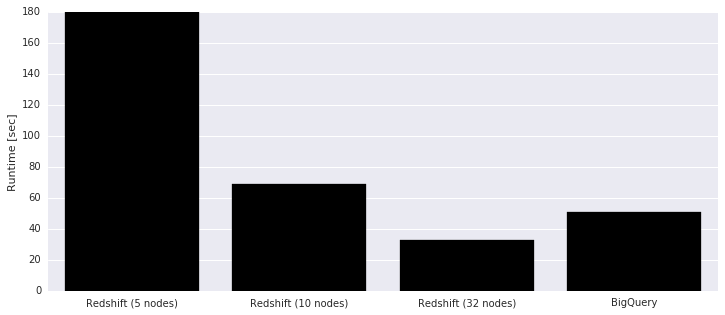

In [4]:
import seaborn as sns
import pandas as pd

plt.figure(figsize=(12, 5))
ax = sns.barplot(x="name", y="run_time", color='k', data=pd.DataFrame([
    # {'name': 'Redshift (single)', 'run_time': 802},
    {'name': 'Redshift (5 nodes)', 'run_time': 180},
    {'name': 'Redshift (10 nodes)', 'run_time': 69},
    {'name': 'Redshift (32 nodes)', 'run_time': 33},
    {'name': 'BigQuery', 'run_time': 51},
]))
ax.set_xlabel("")
ax.set_ylabel("Runtime [sec]")

より詳細な話題は以下の記事に譲る：

* A Full Comparison of Redshift and BigQuery http://panoply.io/blog/a-full-comparison-of-redshift-and-bigquery/
* GOOGLE BIGQUERY BENCHMARK http://doit-intl.com/blog/2015/6/9/bigquery-benchmark

-----

## 画像データの処理

matplotlib, scikit-image, OpenCV はそれぞれ画像を読み込み，RGBカラーモデルのデータ配列を `numpy.ndarray` オブジェクトとして返す関数を提供する．注意点として，`matplotlib.pyplot.imread()` および `skimage.io.imread()` はチャンネル（3時限目）の並びが RGB であるのに対して，`cv2.imread()` 関数は BGR である．

![](http://opencv.jp/cookbook/_images/mat57c3.png)

(OpenCV Cookbook より画像引用 http://opencv.jp/cookbook/opencv_mat.html)

In [90]:
import matplotlib.pyplot as plt
import skimage.io
import cv2


X1 = plt.imread("/mnt/draper/set79_1.jpeg")
X2 = skimage.io.imread("/mnt/draper/set79_1.jpeg")
X3 = cv2.imread("/mnt/draper/set79_1.jpeg")
print("X1", X1.shape, X1.dtype)
print("X2", X2.shape, X2.dtype)
print("X3", X3.shape, X3.dtype)
(X2[:, :, 0] != X3[:, :, 2]).sum()

X1 (2329, 3100, 3) uint8
X2 (2329, 3100, 3) uint8
X3 (2329, 3100, 3) uint8


0

### BRISK 画像特徴点の計算と射影変換 (OpenCV extension)

[Draper Satellite Image Chronology コンテスト](https://www.kaggle.com/c/draper-satellite-image-chronology/) を題材として，画像からのキーポイント抽出や変形について線形変換の手段を紹介する．

DRAPER Satellite Image Chronology は５枚１セットの航空写真を時系列順に並び替える技術を競うコンテストである．以下のような航空写真が与えられる．

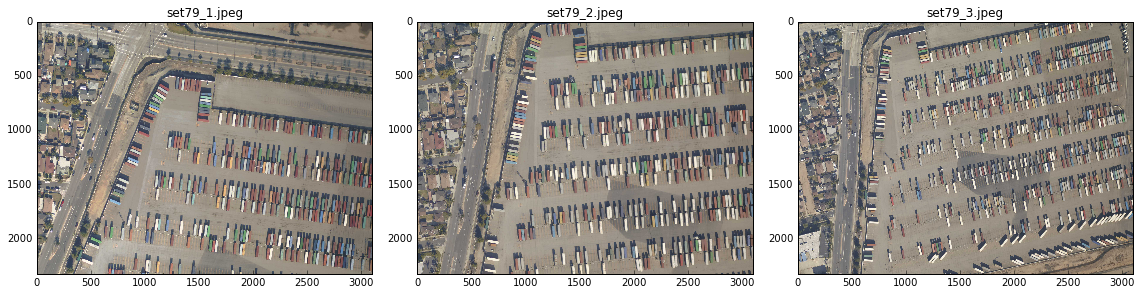

In [62]:
# 5枚1セットのうちの3枚を表示
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))
ax1.set_title("set79_1.jpeg")
ax1.imshow(plt.imread("/mnt/draper/set79_1.jpeg"))
ax2.set_title("set79_2.jpeg")
ax2.imshow(plt.imread("/mnt/draper/set79_2.jpeg"))
ax3.set_title("set79_3.jpeg")
ax3.imshow(plt.imread("/mnt/draper/set79_3.jpeg"))
fig.tight_layout()

それぞれ写真の角度が異なるため，[BRISK 特徴点 [Leutenegger2011]](https://www.robots.ox.ac.uk/~vgg/rg/papers/brisk.pdf) を計算してマッチングを行うことで，射影変換を計算して画像を比較しやすく前処理する．[OpenCV の拡張モジュール](https://github.com/opencv/opencv_contrib) を OpenCV のコンパイル時にオプション指定してインストールすることで，BRISK の OpenCV 実装を利用できる．

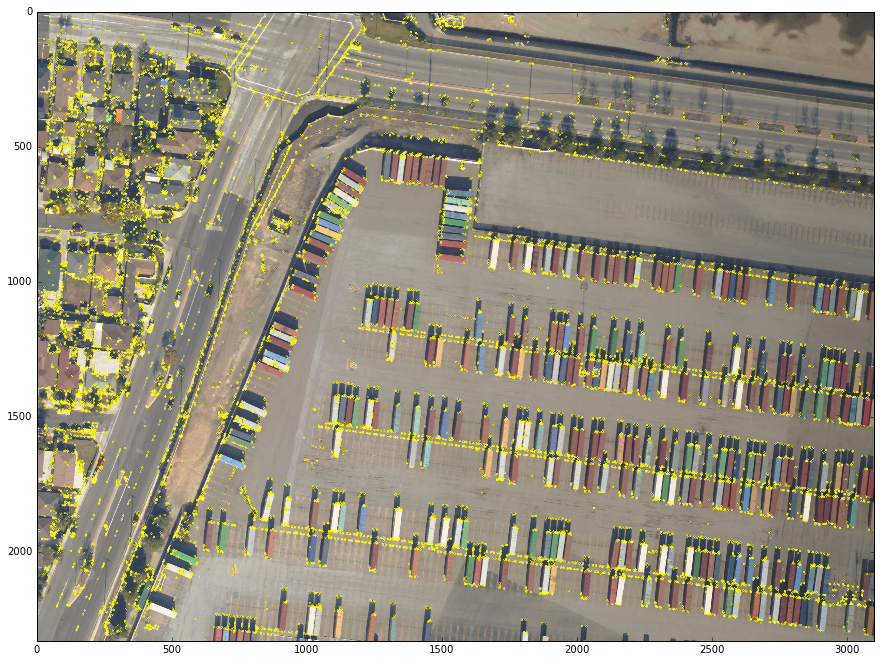

In [43]:
im = plt.imread("/mnt/draper/set79_1.jpeg")
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
brisk_detector = cv2.BRISK_create()
key_points, descs = brisk_detector.detectAndCompute(im_gray, None)
 
cv2.drawKeypoints(im, key_points, im, (255, 255, 0))
plt.figure(figsize=(15,20))
plt.imshow(im)

サンプリングされた BRISK 特徴点を２つの画像にマッチングさせ，射影変換することによって航空写真の角度を修正することができる．

In [53]:
import numpy as np


def homograyphy(im1, im2, im1_gray, im2_gray):
    # BRISK
    brisk = cv2.BRISK_create()
    kp1, des1 = brisk.detectAndCompute(im1_gray, None)
    kp2, des2 = brisk.detectAndCompute(im2_gray, None)

    # MATCH
    dm = cv2.DescriptorMatcher_create("BruteForce-Hamming")
    matches = dm.knnMatch(des1, des2, 2)
    matches_ = []
    for m in matches:
        if len(m) == 2 and m[0].distance < m[1].distance * 0.75:
            matches_.append((m[0].trainIdx, m[0].queryIdx))

    # Calc homography
    kp1_ = np.float32([kp1[m[1]].pt for m in matches_]).reshape(-1,1,2)
    kp2_ = np.float32([kp2[m[0]].pt for m in matches_]).reshape(-1,1,2)
    H, mask = cv2.findHomography(kp2_, kp1_, cv2.RANSAC, 4.0)

    h1, w1 = im1.shape[:2]
    h2, w2 = im2.shape[:2]

    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)

    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)

    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]

    Ht = np.array([
        [1, 0, t[0]],
        [0, 1, t[1]],
        [0, 0, 1]
    ])

    return Ht, H, xmin, xmax, ymin, ymax, mask, t, h1, w1


def downsized_image(fn, pcnt_downsize=0.2):
    im = plt.imread("/mnt/draper/{}".format(fn))

    downsized_dim_im = (int(im.shape[1] * pcnt_downsize), int(im.shape[0] * pcnt_downsize))
    im = cv2.resize(im, downsized_dim_im, interpolation=cv2.INTER_AREA)
    im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return im, im_gray


def calc_mask_shape(ymax_list, xmax_list, im_mask_list):
    ymax, xmax = min(ymax_list), min(xmax_list)
    assert ymax > 0 and xmax > 0

    im_mask = im_mask_list[0][0:ymax, 0:xmax]
    for i in range(1, len(im_mask_list)):
        im_mask = im_mask * im_mask_list[i][0:ymax, 0:xmax]
    return ymax, xmax, im_mask


def compare_homography_trafo_images(*fn_list):
    im_list, im_gray_list = [], []
    im_mask_list = []
    im_morph_list, im_morph_color_list = [], []
    ymax_list, xmax_list = [], []

    n_images = len(fn_list)
    for i, fn in enumerate(fn_list):
        im_, im_gray_ = downsized_image(fn, pcnt_downsize=0.2)
        im_list.append(im_)
        im_gray_list.append(im_gray_)

        # calc homography
        Ht, H, xmin, xmax, ymin, ymax, mask, t, h1, w1 = homograyphy(im_list[0], im_, im_gray_list[0], im_gray_)
        ymax_list.append(ymax)
        xmax_list.append(xmax)

        # mask
        im_mask = np.uint8(np.ones((im_.shape[0], im_.shape[1])))
        im_mask = cv2.warpPerspective(im_mask, Ht.dot(H), (xmax-xmin, ymax-ymin))
        im_mask = im_mask[t[1]:, t[0]:]
        im_mask_list.append(im_mask)

        # morph color
        im_mc = np.uint8(np.ones((im_.shape[0], im_.shape[1])))
        im_morph = cv2.warpPerspective(im_, Ht.dot(H), (xmax-xmin, ymax-ymin))
        im_morph = im_morph[t[1]:, t[0]:, :]
        im_morph_color_list.append(im_morph)

        # morph
        im_morph = cv2.warpPerspective(im_, Ht.dot(H), (xmax-xmin, ymax-ymin))
        im_morph = cv2.cvtColor(im_morph, cv2.COLOR_BGR2GRAY)
        im_morph = im_morph[t[1]:, t[0]:]
        im_morph_list.append(im_morph)

    ymax, xmax, im_mask = calc_mask_shape(ymax_list, xmax_list, im_mask_list)
    im_mc_list = []

    for i in range(n_images):
        im_mc = np.uint8(np.zeros((ymax, xmax, 3)))
        for ch in range(3):
            im_mc[:, :, ch] = im_morph_color_list[i][0:ymax, 0:xmax, ch] * im_mask
        im_mc_list.append(im_mc)

    fig, ax_list = plt.subplots(1, n_images, figsize=(14, 10))
    for i in range(n_images):
        ax_list[i].imshow(im_mc_list[i])
    plt.tight_layout()

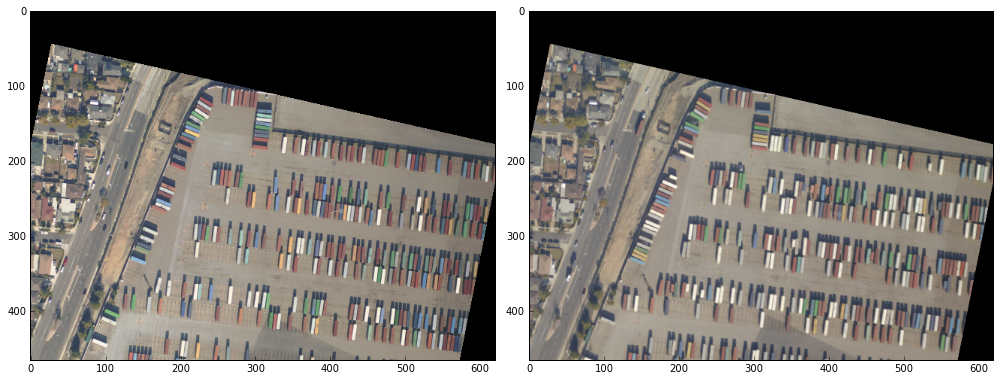

In [54]:
compare_homography_trafo_images("set79_1.jpeg", "set79_2.jpeg")

特徴点のマッチング結果からホモグラフィを計算し，`set79_1.jpeg` の角度・スケールにあわせて `set79_2.jpeg` を変形した．
道路やコンテナの角度が一致していることが確認できる．

さらに\ピクセル単位での比較を行うことで，画像の差分をわかりやすく可視化することができる．

In [63]:
def visualize_diff(idx1, idx2, im_mask, im_morph_list, ymax, xmax):
    im = np.ones((im_mask.shape[0], im_mask.shape[1], 3), np.uint8)

    im_morph = im_morph_list[idx1 - 1][0:ymax, 0:xmax]
    ret, im_thresh = cv2.threshold(im_morph, 107, 255, cv2.THRESH_BINARY)
    im_thresh = im_thresh * im_mask
    im[:, :, 1] = im[:, :, 1] * im_thresh
    im[:, :, 2] = im[:, :, 2] * im_thresh

    im_morph = im_morph_list[idx2 - 1][0:ymax, 0:xmax]
    ret, im_thresh = cv2.threshold(im_morph, 107, 255, cv2.THRESH_BINARY)
    im_thresh = im_thresh * im_mask
    im[:, :, 0] = im[:, :, 0] * im_thresh

    diff_sz = np.sum(np.abs(im[:, :, 0] - im[:, :, 1]))
    return im, diff_sz


def calc_mask_for_comparing_images(fn1, fn2):
    im_list, im_gray_list = [], []
    im_mask_list, im_morph_list, im_morph_color_list = [], [], []
    ymax_list, xmax_list = [], []

    for fn in [fn1, fn2]:
        im_, im_gray_ = downsized_image(fn, pcnt_downsize=0.8)
        im_list.append(im_)
        im_gray_list.append(im_gray_)

        # calc homography
        Ht, H, xmin, xmax, ymin, ymax, mask, t, h1, w1 = homograyphy(im_list[0], im_, im_gray_list[0], im_gray_)
        ymax_list.append(ymax)
        xmax_list.append(xmax)

        # mask
        im_mask = np.uint8(np.ones((im_.shape[0], im_.shape[1])))
        im_mask = cv2.warpPerspective(im_mask, Ht.dot(H), (xmax-xmin, ymax-ymin))
        im_mask = im_mask[t[1]:, t[0]:]
        im_mask_list.append(im_mask)

        # morph color
        im_mc = np.uint8(np.ones((im_.shape[0], im_.shape[1])))
        im_morph = cv2.warpPerspective(im_, Ht.dot(H), (xmax-xmin, ymax-ymin))
        im_morph = im_morph[t[1]:, t[0]:, :]
        im_morph_color_list.append(im_morph)

        # morph
        im_morph = cv2.warpPerspective(im_, Ht.dot(H), (xmax-xmin, ymax-ymin))
        im_morph = cv2.cvtColor(im_morph, cv2.COLOR_BGR2GRAY)
        im_morph = im_morph[t[1]:, t[0]:]
        im_morph_list.append(im_morph)

    ymax, xmax, im_mask = calc_mask_shape(ymax_list, xmax_list, im_mask_list)

    idx1, idx2 = 1, 2
    im_viz, diff_sz = visualize_diff(idx1, idx2, im_mask, im_morph_list, ymax, xmax)
    im_mc1 = np.uint8(np.zeros((ymax, xmax, 3)))
    im_mc2 = np.uint8(np.zeros((ymax, xmax, 3)))
    for ch in range(3):
        im_mc1[:, :, ch] = im_morph_color_list[idx1 - 1][0:ymax, 0:xmax, ch] * im_mask
        im_mc2[:, :, ch] = im_morph_color_list[idx2 - 1][0:ymax, 0:xmax, ch] * im_mask

    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    ax.imshow(im_viz)
    plt.tight_layout()

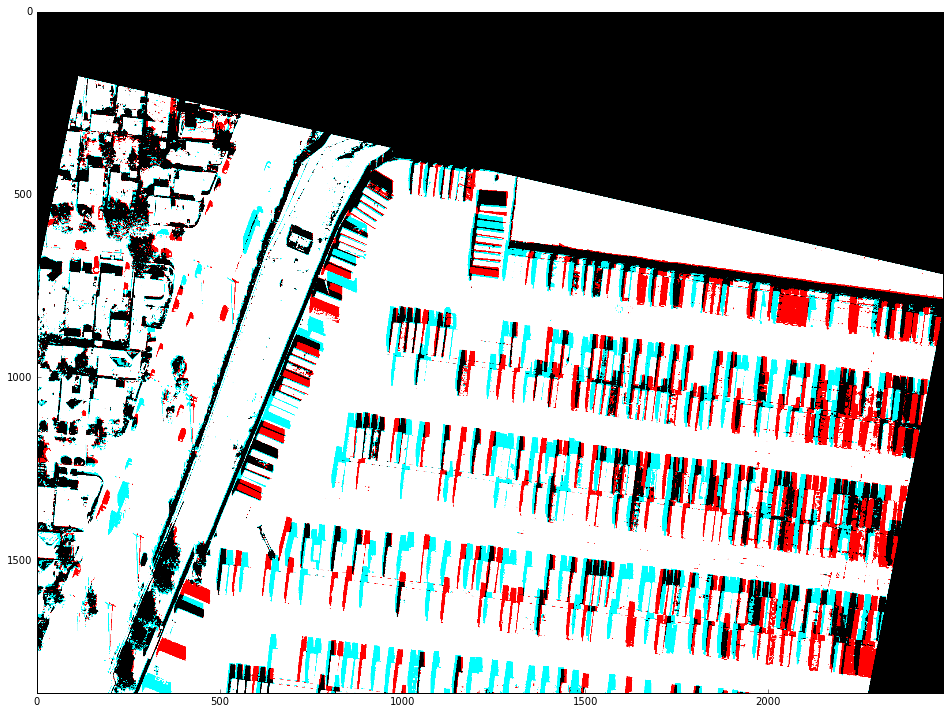

In [64]:
calc_mask_for_comparing_images("set79_1.jpeg", "set79_2.jpeg")

上の可視化では

* 「左の画像だけ二値画像のピクセルが黒である場合をシアン」
* 「右の画像だけ二値画像のピクセルが黒である場合をレッド」

として二値化した画像の差分を可視化している．

（※ 可視化のアイディアは Forum に投稿されたトピック「[Tutorial: visualizing difference between three pictures](https://www.kaggle.com/c/draper-satellite-image-chronology/forums/t/21209/tutorial-visualizing-difference-between-three-pictures)」から．可視化はこれを実装したものである）

ここでは画像特徴点を射影変換の計算のために用いたが，[機械学習モデルの特徴量としても有用である場合がある](http://blog.kaggle.com/2016/08/24/avito-duplicate-ads-detection-winners-interview-1st-place-team-devil-team-stanislav-dmitrii/)．